# Sample Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-26 11:25:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  19.0MB/s    in 0.8s    

2021-12-26 11:25:02 (19.0 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-26 11:25:02--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.1MB/s    in 0.7s    

202

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [88]:
metadata["rankNumber"] = pd.to_numeric(metadata["rank"].str.split().str[0].str.split(",").str.join(''), downcast='signed', errors='coerce')
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,rankNumber
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[],2938573.0
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[],872854.0
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[],956696.0
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,1870258.0
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,67701.0


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [6]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [7]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 了解資料



1. 測試集中有沒有歷史資料的新客戶。[考量沒歷史資料者怎麼分析]
2. 即使有歷史資料，單人的購買數量基本不多
3. 訓練資料從2000-2018，測試資料只有2018-0901(一個月
4. 從訓練資料可看出2017-2018年，評分median為5分者，通常為熱銷款[***]
5. (無品牌|'TIGI')似乎受大家歡迎[***]





In [8]:
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
# 使用者群分析-train

attention_products_train = defaultdict(int)
products_overall_train  = defaultdict(lambda: 0)

maxNumber = 0
maxList  = []
for i in range(len(ratings_trainings)):
  user  = ratings_trainings.iloc[i,1]
  product = ratings_trainings.iloc[i,0]
  score  = ratings_trainings.iloc[i,2]
  attention_products_train[product] += 1
  products_overall_train[product] += score
  if maxNumber < attention_products_train[product]:
    maxList = [product]
    maxNumber = attention_products_train[product]
  elif maxNumber == attention_products_train[product]:
    maxList.append(product)
print("MaxNumber = {0}, List = {1}".format(maxNumber, maxList))

attention_list_train = defaultdict(list)
for k, v in attention_products_train.items():
  attention_list_train[v].append(k)

attention_list_train

"""
             973: ['B000H6A02A', 'B00NT0AR7E'],
             987: ['B00JVU3K9I'],
             1006: ['B000URXP6E'],
             1020: ['B000VV1YOY'],
             1079: ['B00D3M0CRS'],
             1080: ['B00G5L867C'],
             1088: ['B0013NB7DW'],
             1128: ['B000EG8HLE'],
             1136: ['B0010ZBORW'],
             1223: ['B008U1Q4DI'],
             1329: ['B001AJ6YS2'],
             1330: ['B000FED5DU'],
             1538: ['B000050FDY'],
             1770: ['B00BMVV3MK'],
             1850: ['B0067F28ZW'],
             1964: ['B00VF344X0'],
             2190: ['B000WYJTZG'],
             2234: ['B0012Y0ZG2'],
             2249: ['B00005JS5C'],
             2790: ['B006IB5T4W'],
             2959: ['B00W259T7G'],
             4197: ['B01DKQAXC0'],
             4544: ['B001QY8QXM'],
             4792: ['1620213982'],
             8341: ['B000GLRREU'],
             8672: ['B000FOI48G']})
"""

In [ ]:
# 新使用者群分析
new_users = list(set(ratings_testings["reviewerID"]) - set(ratings_trainings["reviewerID"]))
print("new users number: ",len(new_users))
attention_products = defaultdict(int)
products_overall  = defaultdict(lambda: 0)

maxNumber = 0
maxList  = []
for i in range(len(ratings_testings)):
  user  = ratings_testings.iloc[i,1]
  product = ratings_testings.iloc[i,0]
  score  = ratings_testings.iloc[i,2]
  if user in new_users:
    attention_products[product] += 1
    products_overall[product] += score
    if maxNumber < attention_products[product]:
      maxList = [product]
      maxNumber = attention_products[product]
    elif maxNumber == attention_products[product]:
      maxList.append(product)

print("MaxNumber = {0}, List = {1}".format(maxNumber, maxList))

attention_list = defaultdict(list)
for k, v in attention_products.items():
  attention_list[v].append(k)

attention_list

"""
             4: ['B01AMOTPI6',
              'B01C74U1UU',
              'B01CW24JXC',
              'B01DXFHFX8',
              'B01GLA54SA',
              'B01H3IVSAC'],
             5: ['B01C4ZAPGM',
              'B01CTIJEIY',
              'B01CX5KCIE',
              'B01DFHDMS6',
              'B01FT6TMQM'],
             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],
             7: ['B0195R1FT8', 'B01AVJCDYA'],
             9: ['B018WCT01C', 'B01FWDHKPC'],
             10: ['B01FWP41H0'],
             13: ['B01CJNZKZK'],
             14: ['B01ENS6XDC'],
             48: ['B01DKQAXC0']})

"""


In [11]:
ratings_testings['year'] = ratings_testings["DATE"].dt.year
ratings_trainings['year'] = ratings_trainings["DATE"].dt.year

ratings_testings.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,asin,reviewerID,overall,unixReviewTime,DATE,year
234795,B01CJNZKZK,A38KP6TI3BUIM6,1.0,1536192000,2018-09-06,2018
234796,B01CJNZKZK,A2H7VSYLKGKLLJ,1.0,1535932800,2018-09-03,2018
234797,B01CJNZKZK,A1119JJ37ZLB8R,5.0,1535932800,2018-09-03,2018
240438,B01DKQAXC0,A1FKUBRPLG6Y8I,5.0,1537401600,2018-09-20,2018
240439,B01DKQAXC0,A2WX2YLLHJDLX7,5.0,1537315200,2018-09-19,2018


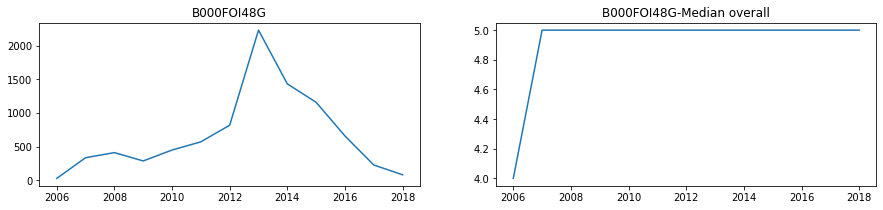

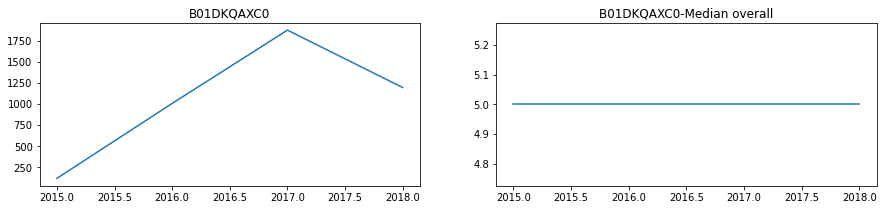

In [12]:
def drawProduct_buyline(productName, df):
  tmp = df[df["asin"] == productName]

  record = {}
  score = {}
  for year in range(min(tmp["year"]), max(tmp["year"])+1):
    a = tmp[tmp["year"]==year]
    # record[year] = [len(a), a["overall"].median()]
    record[year] = [len(a), a["overall"].quantile(.4)]

  tmp = pd.DataFrame.from_dict(record, orient='index').rename(columns={0:'Amount', 1:'Overall'})

  plt.subplot(1, 2, 1)
  tmp["Amount"].plot(title=productName, figsize=(15,3))
  plt.subplot(1, 2, 2)
  tmp["Overall"].plot(title=productName+"-Median overall", figsize=(15,3))
  plt.show()

drawProduct_buyline('B000FOI48G', ratings_trainings)
drawProduct_buyline('B01DKQAXC0', ratings_trainings)

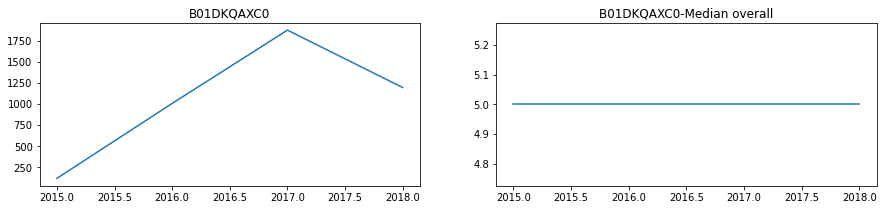

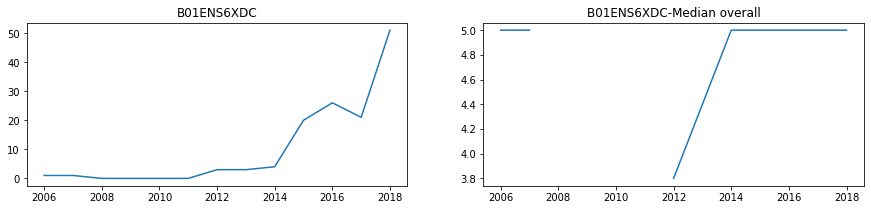

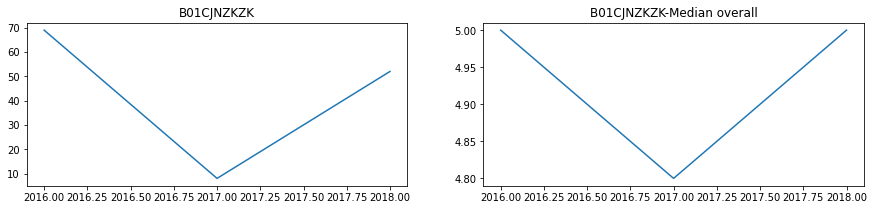

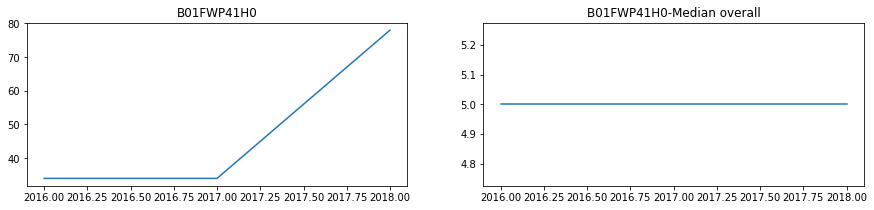

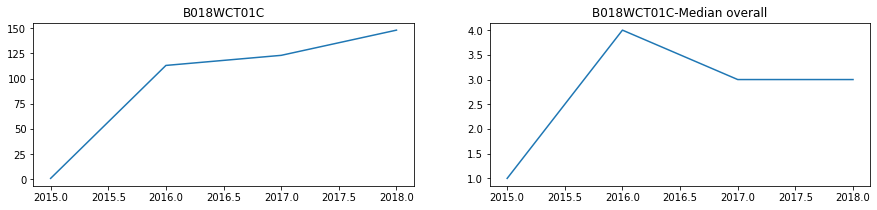

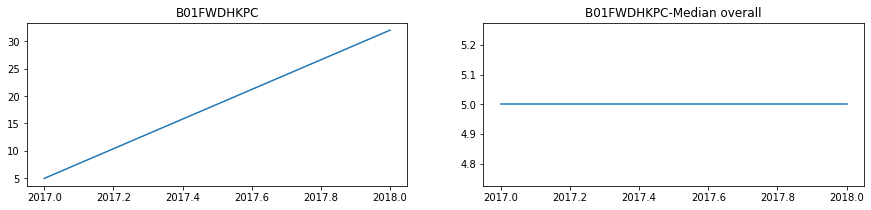

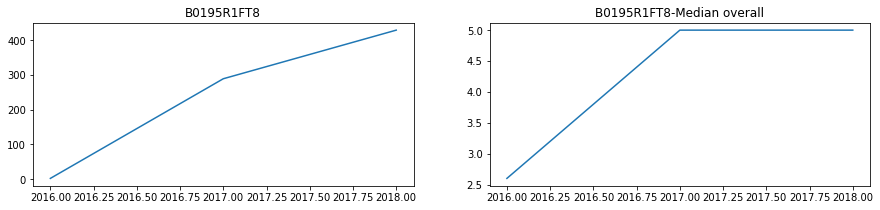

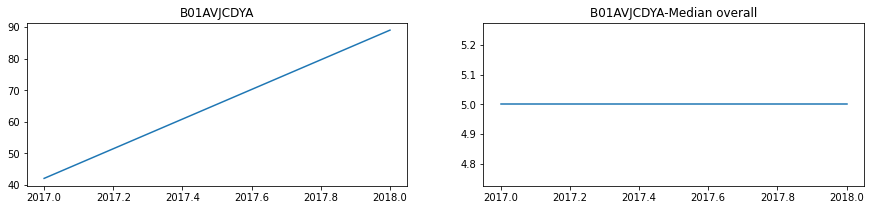

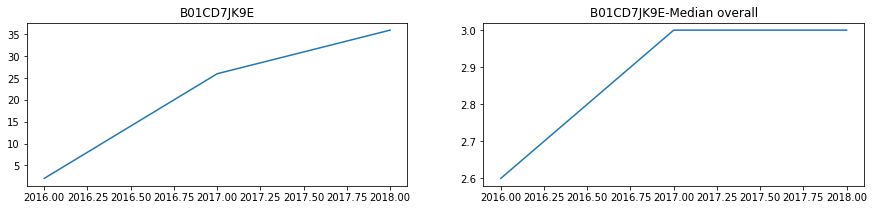

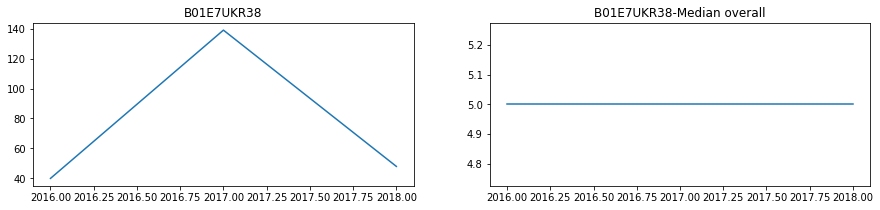

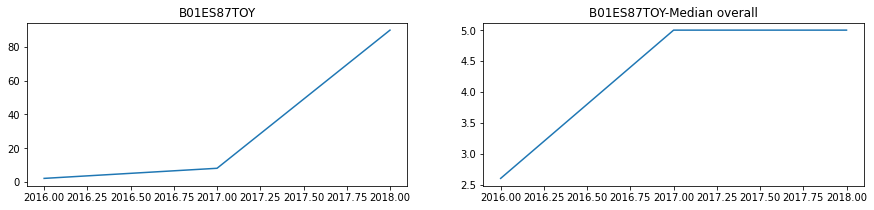

"\n             5: ['B01C4ZAPGM',\n              'B01CTIJEIY',\n              'B01CX5KCIE',\n              'B01DFHDMS6',\n              'B01FT6TMQM'],\n             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],\n             7: ['B0195R1FT8', 'B01AVJCDYA'],\n             9: ['B018WCT01C', 'B01FWDHKPC'],\n             10: ['B01FWP41H0'],\n             13: ['B01CJNZKZK'],\n             14: ['B01ENS6XDC'],\n             48: ['B01DKQAXC0']})\n"

In [13]:
drawProduct_buyline('B01DKQAXC0', ratings_trainings)
drawProduct_buyline('B01ENS6XDC', ratings_trainings)
drawProduct_buyline('B01CJNZKZK', ratings_trainings)
drawProduct_buyline('B01FWP41H0', ratings_trainings)
drawProduct_buyline('B018WCT01C', ratings_trainings)
drawProduct_buyline('B01FWDHKPC', ratings_trainings)
drawProduct_buyline('B0195R1FT8', ratings_trainings)
drawProduct_buyline('B01AVJCDYA', ratings_trainings)
drawProduct_buyline('B01CD7JK9E', ratings_trainings)
drawProduct_buyline('B01E7UKR38', ratings_trainings)
drawProduct_buyline('B01ES87TOY', ratings_trainings)

"""
             5: ['B01C4ZAPGM',
              'B01CTIJEIY',
              'B01CX5KCIE',
              'B01DFHDMS6',
              'B01FT6TMQM'],
             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],
             7: ['B0195R1FT8', 'B01AVJCDYA'],
             9: ['B018WCT01C', 'B01FWDHKPC'],
             10: ['B01FWP41H0'],
             13: ['B01CJNZKZK'],
             14: ['B01ENS6XDC'],
             48: ['B01DKQAXC0']})
"""

In [14]:
current_trainings = ratings_trainings[(ratings_trainings['DATE'] >= '2018-07-01') & (ratings_trainings['DATE'] <= '2018-09-01')]

groups = current_trainings.groupby("asin")
# tmp   = groups["overall"].median()
tmp1   = groups["overall"].quantile(.4)
tmp2   = groups.size()
current_score5_products = list(tmp1[(tmp1>=5) & (tmp2 >= 8)].index)
print("current total = "+str(len(current_score5_products)))

# ====
lastyear_trainings = ratings_trainings[(ratings_trainings['DATE'] >= '2017-08-01') & (ratings_trainings['DATE'] <= '2017-11-01')]

groups = lastyear_trainings.groupby("asin")
# tmp   = groups["overall"].median()
tmp1   = groups["overall"].quantile(.4)
tmp2   = groups.size()
lastyear_score5_products = list(tmp1[(tmp1>=5) & (tmp2 >= 12)].index)
print("lastyear total = "+str(len(lastyear_score5_products)))

print("Overlap = ",len(set(current_score5_products) & set(lastyear_score5_products)))

current total = 38
lastyear total = 105
Overlap =  15


In [129]:
def score5_products(time1, time2, limitNumber, ratio, originalData, productList, weight):
  tmpData = originalData[(originalData['DATE'] >= time1) & (originalData['DATE'] <= time2)]

  groups = tmpData.groupby("asin")
  # tmp   = groups["overall"].median()
  tmp1   = groups["overall"].quantile(ratio)
  tmp2   = groups.size()
  current_score5_products = list(tmp1[(tmp1>=5) & (tmp2 >= limitNumber)].index)
  for product in current_score5_products:
    productList[product] += weight
  return current_score5_products

def addweight(originalData, add_Products, keyType, productList, weight):
  removeList = []
  for asin in add_Products:
    tmpData = originalData[originalData["asin"] == asin]
    if len(tmpData) == 0:
      removeList.append(asin)
      continue
    for addproduct in tmpData[keyType].iloc[0]:
      productList[addproduct] += weight
  
  for product in removeList:
    del(productList[product])

def getInfo_by_key(keyTpye, productList, subKeys=None):
  final = []
  for name, n in productList.items():
    tmp = metadata[metadata["asin"]==name][keyTpye]
    if len(tmp) > 0:
      if subKeys == None or tmp.iloc[0] in subKeys:
        final.append([name, tmp.iloc[0]])
  return final

def detect_Number(checkList, attention_products):
  totalN = sum([n for n in attention_products.values()])
  total = len(attention_products)

  getGoal = 0
  getNumber = 0
  for product in checkList:
    if product[0] in attention_products:
      getNumber += attention_products[product[0]]
      getGoal += 1

  print("{0} / {1} : {2} / {3} : {4}".format(getGoal,total,getNumber,totalN,round(getNumber/totalN,2)))



In [130]:
productList = defaultdict(int)
current_score5_products = score5_products('2018-07-01', '2018-09-01', 8, 0.4, ratings_trainings, productList, weight=20)
# addweight(metadata, current_score5_products, "also_buy", productList, weight=10)
# addweight(metadata, current_score5_products, "also_view", productList, weight=1)

lastyear_score5_products = score5_products('2017-08-01', '2017-11-01', 12, 0.4, ratings_trainings, productList, weight=10)
# addweight(metadata, current_score5_products, "also_buy", productList, weight=5)
# addweight(metadata, current_score5_products, "also_view", productList, weight=1)

#=== by weighting --> 沒有明顯差異
# final = sorted([[name, n] for name, n in productList.items()], key=lambda x:-x[1])#[:20]

#=== by rankNumber --> 排名90-100數量最多(奇怪)
# final = getInfo_by_key("rankNumber", productList)

#=== by price --> 看不出來
# final = getInfo_by_key("price", productList)

#=== by brand --> (無品牌|'TIGI')似乎受大家歡迎[###]
final = getInfo_by_key("brand", productList, subKeys=["", 'TIGI'])

final = sorted(final, key=lambda x:x[1])

print("total predict products = ",len(final))
detect_Number(final, attention_products)

# 36 / 316 : 189 / 551 : 0.34 | 128
# 7 / 316 : 80 / 551 : 0.15 | 10



total predict products =  10
7 / 316 : 80 / 551 : 0.15


In [127]:
detect_Number(final[106:108], attention_products)
detect_Number(final[:8], attention_products)

2 / 316 : 19 / 551 : 0.03
5 / 316 : 61 / 551 : 0.11


In [116]:

print("total predict products = ",len(final))
for i in range(0,130,10):
  print(i," -> ",i+10)
  detect_Number(final[i:i+10], attention_products)

total predict products =  127
0  ->  10
5 / 316 : 61 / 551 : 0.11
10  ->  20
2 / 316 : 14 / 551 : 0.03
20  ->  30
4 / 316 : 10 / 551 : 0.02
30  ->  40
2 / 316 : 10 / 551 : 0.02
40  ->  50
3 / 316 : 5 / 551 : 0.01
50  ->  60
2 / 316 : 11 / 551 : 0.02
60  ->  70
4 / 316 : 11 / 551 : 0.02
70  ->  80
2 / 316 : 6 / 551 : 0.01
80  ->  90
3 / 316 : 11 / 551 : 0.02
90  ->  100
3 / 316 : 17 / 551 : 0.03
100  ->  110
5 / 316 : 31 / 551 : 0.06
110  ->  120
1 / 316 : 2 / 551 : 0.0
120  ->  130
0 / 316 : 0 / 551 : 0.0


In [ ]:
[[name, metadata[metadata["asin"]==name]]["rankNumber"].iloc[0]] for name, n in productList.items()]

for name, n in productList.items():
  print(metadata["asin"==name]["rankNumber"])

In [108]:
final[90:100]

[['B01DKQAXC0', 152867.0],
 ['B00X8LM98Y', 155464.0],
 ['B001P2NRPC', 156001.0],
 ['B015ZTNN7W', 158083.0],
 ['B01CJNZKZK', 177226.0],
 ['B019809F9Y', 185717.0],
 ['B00FIUEIY6', 195114.0],
 ['B01D8030L4', 197777.0],
 ['B0189NOD4I', 202534.0],
 ['B017BJ8KFE', 203584.0]]

In [ ]:
'''
             4: ['B01AMOTPI6',
              'B01C74U1UU',
              'B01CW24JXC',
              'B01DXFHFX8',
              'B01GLA54SA',
              'B01H3IVSAC'],
             5: ['B01C4ZAPGM',
              'B01CTIJEIY',
              'B01CX5KCIE',
              'B01DFHDMS6',
              'B01FT6TMQM'],
             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],
             7: ['B0195R1FT8', 'B01AVJCDYA'],
             9: ['B018WCT01C', 'B01FWDHKPC'],
             10: ['B01FWP41H0'],
             13: ['B01CJNZKZK'],
             14: ['B01ENS6XDC'],
             48: ['B01DKQAXC0']})
'''

In [ ]:
ratings_trainings[ratings_trainings["reviewerID"] == "A13JU88JAHN72I"]

In [ ]:
ratings_testings[ratings_testings["reviewerID"] == "A13JU88JAHN72I"]

In [ ]:
tmp = metadata[(metadata["asin"] == "B009YDVB6Q") | (metadata["asin"] == "B017I6B6GK")]
tmp.head()

In [ ]:
tmp["also_buy"].iloc[1]

## 產生推薦

In [9]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    Your Code
    '''
    return recommendations


ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{}

## 結果評估

In [10]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0